### Initialization
- Import modules
- Define file formatter
- Define plotters

In [238]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from os import listdir

from utils import load_imputed_data

# folders and paths
imputed_data_folder = 'imputed_data'
initializations_folder = 'imputed_data_initializations'
metrics_folder = 'imputed_data_metrics'


def format_and_save(filename="metrics"):
    # Load imputed data
    imputed_data = load_imputed_data(imputed_data_folder)
    if not imputed_data: return

    # Convert to DataFrame
    imputed_data = pd.DataFrame(imputed_data)

    # Add (partial) header
    header = ['dataset', 'miss_rate', 'method', 'init', 'sparsity']
    for i in range(imputed_data.shape[1] - 5): header.append(f'rmse_{i}')
    imputed_data.columns = header

    # Calculate and append the RMSE mean and sd
    means = []
    sds = []
    for row in imputed_data.values:
        rmses = [float(n) for n in row[5:] if n is not None]
        means.append(f'{np.mean(rmses):.4f}')
        sds.append(f'{np.std(rmses):.7f}')
    imputed_data['rmse_mean'] = means
    imputed_data['rmse_sd'] = sds

    # Get the initializations
    inits = listdir(initializations_folder)
    experiments = {}
    for file in inits:
        # Get the experiment as a key
        split = file.split('_')
        data_name = split[0]
        miss_rate = float(split[2])
        method = split[3]
        init = split[4]
        sparsity = float(split[6])
        rmse = float('0.' + split[8].split('.')[1])
        i = 0 if split[9] == 'G' else int(split[9])
        exp = (data_name, miss_rate, method, init, sparsity, rmse, i)

        # Get the initialization as a key and value
        G_Wi = 'G_' + split[-1].split('.')[0]
        G_Wx = pd.read_csv(f'{initializations_folder}/{file}', header=None).to_numpy()

        # Store the experiment with a dictionary of its initialization masks
        if exp not in experiments:
            experiments[exp] = {G_Wi: G_Wx}
        else:
            experiments[exp].update({G_Wi: G_Wx})

    # Todo Calculate the FLOPs
    for key, masks in experiments.items():
        sparsity = key[4]
        flops = None  # get_flops(masks, sparsity)
        imputed_data.loc[
            (imputed_data['dataset'] == key[0])
            & (imputed_data['miss_rate'].astype('float') == key[1])
            & (imputed_data['method'] == key[2])
            & (imputed_data['init'] == key[3])
            & (imputed_data['sparsity'].astype('float') == sparsity),
            ['flops']
        ] = flops

    # Append the successes, failures, success_rate and failure_rate
    saf = pd.read_csv(f'{metrics_folder}/successes_and_failures.csv')
    for dataset, miss_rate, method, init, sparsity, successes, failures in saf.values:
        success_rate = (successes / (successes + failures))
        failure_rate = 1 - success_rate
        if not imputed_data.loc[
            (imputed_data['dataset'] == dataset)
            & (imputed_data['miss_rate'].astype('float') == miss_rate)
            & (imputed_data['method'] == method)
            & (imputed_data['init'] == init if pd.notna(init) else imputed_data['init'] == '')
            & (imputed_data['sparsity'].astype('float') == sparsity)
        ].empty:
            imputed_data.loc[
                (imputed_data['dataset'] == dataset)
                & (imputed_data['miss_rate'].astype('float') == miss_rate)
                & (imputed_data['method'] == method)
                & (imputed_data['init'] == init if pd.notna(init) else imputed_data['init'] == '')
                & (imputed_data['sparsity'].astype('float') == sparsity),
                ['successes', 'failures', 'success_rate', 'failure_rate']
            ] = str(successes), str(failures), f'{success_rate:.4f}', f'{failure_rate:.4f}'
        else:
            row = [dataset, str(miss_rate), method, init, sparsity]
            for i in range(len(imputed_data.columns) - 9): row.append(None)
            row += [str(successes), str(failures), f'{success_rate:.4f}', f'{failure_rate:.4f}']
            row = pd.DataFrame([row], columns=imputed_data.columns)
            imputed_data = pd.concat([imputed_data, row])

    # Sort the data by: dataset, method, init, miss_rate, sparsity (*in order of priority)
    imputed_data.sort_values(['dataset', 'method', 'init', 'miss_rate', 'sparsity'], inplace=True)

    # Save the formatted file
    imputed_data.to_csv(f'{metrics_folder}/{filename}.csv', index=False)

    return imputed_data


def plot_rmse(metrics, CI=None, save=False):
    def _talpha(val, n):
        return st.t.ppf((1 + val) / 2, n - 1)

    # Assuming normal (two-tailed) distribution
    # Todo: calculate for each experiment individually, to account for removal of outliers
    n_runs = metrics.shape[1] - 12
    if CI is not None:
        a = _talpha(CI, n_runs)
        CI = int(CI * 100)  # For output as percentage
    else:
        a = 1

    a_print = f'{a:.3f}'.rstrip('0').rstrip('.')

    # Create plots for every different dataset and miss_rate, group by initialization
    for dataset_miss_rate, dataset_miss_rate_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        plt.figure()
        init_legend = {}
        for method_init, method_init_group in dataset_miss_rate_group.groupby(['method', 'init'], dropna=False):
            method_init = ' '.join(method_init)
            if method_init == 'GAIN ER': method_init = 'GAIN Erdos Renyi'

            x = method_init_group['sparsity'].astype('float')
            y = method_init_group['rmse_mean'].astype('float')
            e = method_init_group['rmse_sd'].astype('float') * a

            if method_init == 'GAIN dense':
                y_mu = y.iloc[0]
                y_sigma = y_mu - e.iloc[0], y_mu + e.iloc[0]
                line = plt.axhline(y=y_mu, color='black', linewidth=1)
                plt.axhline(y=y_sigma[0], color='black', linewidth=1, linestyle='--')
                plt.axhline(y=y_sigma[1], color='black', linewidth=1, linestyle='--')
                init_legend[method_init] = line
            else:
                line = plt.errorbar(x, y, e, marker='o', markersize=3, capsize=5, elinewidth=1, label=method_init)
                plt.fill_between(x, y - e, y + e, alpha=0.2)
                init_legend[method_init] = line

        # Print CI or not
        ci_print = f', CI: {CI}%' if CI is not None else ''

        # Plot parameters
        plt.title(f'{dataset}: {miss_rate}% missing data ({n_runs} runs)'
                  f'\nRMSE v sparsity, grouped by method and initialization{ci_print}')
        plt.xlabel('sparsity level')
        plt.ylabel(f'RMSE ± {a_print} SD')
        plt.legend(init_legend.values(), init_legend.keys(), title='Method and initialization')
        plt.grid(True)

        if save:
            path = f'{metrics_folder}/RMSE_{dataset}_missrate_{miss_rate / 100}.png'
            plt.savefig(path)

        plt.show()


def plot_success_rate(metrics, save=False):
    n_runs = metrics.shape[1] - 12

    # Create plots for every different dataset and miss_rate, group by initialization
    for dataset_miss_rate, dataset_group in metrics.groupby(['dataset', 'miss_rate']):
        dataset, miss_rate = dataset_miss_rate[0], int(float(dataset_miss_rate[1]) * 100)

        plt.figure(figsize=(12.8, 4.8))
        for method_init_sparsity, method_init_sparsity_group in dataset_group.sort_values(
                ['sparsity', 'method', 'init']).groupby(['method', 'init', 'sparsity'], dropna=False):
            # if method_init_sparsity[1] == 'ER': method_init_sparsity[1] = 'Erdos Renyi'

            x = ' '.join(method_init_sparsity[:2]) + '\n' + str(
                int(float(method_init_sparsity[2]) * 100)) + '% sparsity'
            y = method_init_sparsity_group['success_rate']

            # print(dataset, miss_rate, *method_init_sparsity)
            # print('-' * 60)
            # print(y)
            y = y.astype('float')
            # print('-' * 60)
            # print(y)

            plt.bar(x, y)

        plt.title(f'{dataset}: {miss_rate}% missing data ({n_runs} runs)'
                  f'\nSuccess rate')

        if save:
            path = f'{metrics_folder}/Success_rate_{dataset}_missrate_{miss_rate / 100}.png'
            plt.savefig(path)

        plt.show()


def plot_FLOPs(metrics):
    pass


def plot_accuracy(metrics):
    pass


def box_plot(metrics, IQR=1.5):
    # Create plots for every different dataset and miss_rate
    for dataset_miss_rate, dataset_group in metrics.groupby(['dataset', 'miss_rate']):
        label_rmses = {}
        for row in dataset_group.values:
            dataset, miss_rate, method, init, sparsity = row[:5]
            rmses = [float(rmse) for rmse in row[5:-7] if rmse is not None]
            label_rmses.update({f'{method} {init} {int(float(sparsity) * 100)}% sparsity': rmses})

        plt.figure()
        plt.title(f'{dataset}: {int(float(miss_rate) * 100)}% missing data')
        plt.boxplot(label_rmses.values(), tick_labels=label_rmses.keys(), vert=False, whis=IQR)



### Format and save the results

In [239]:
metrics = format_and_save()

KeyError: ('dataset', 'method')

### Plot RMSE, failure_rate, FLOPs and accuracy

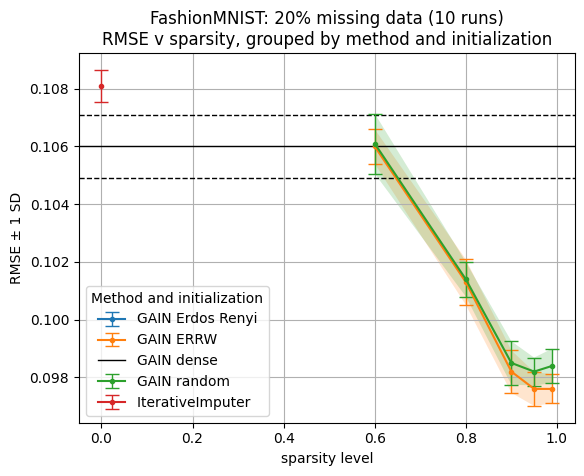

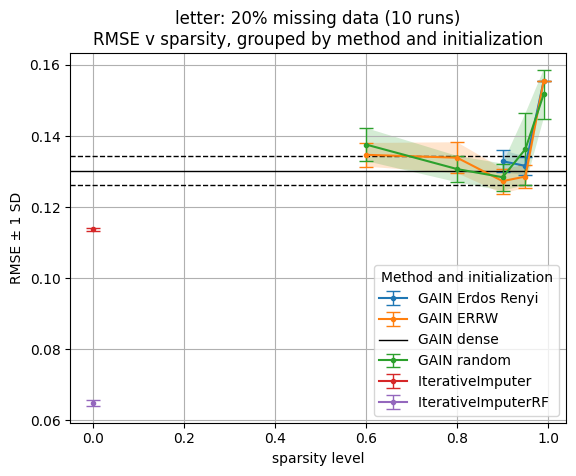

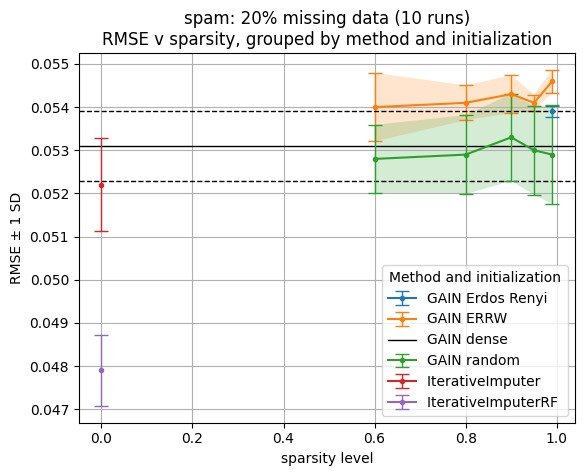

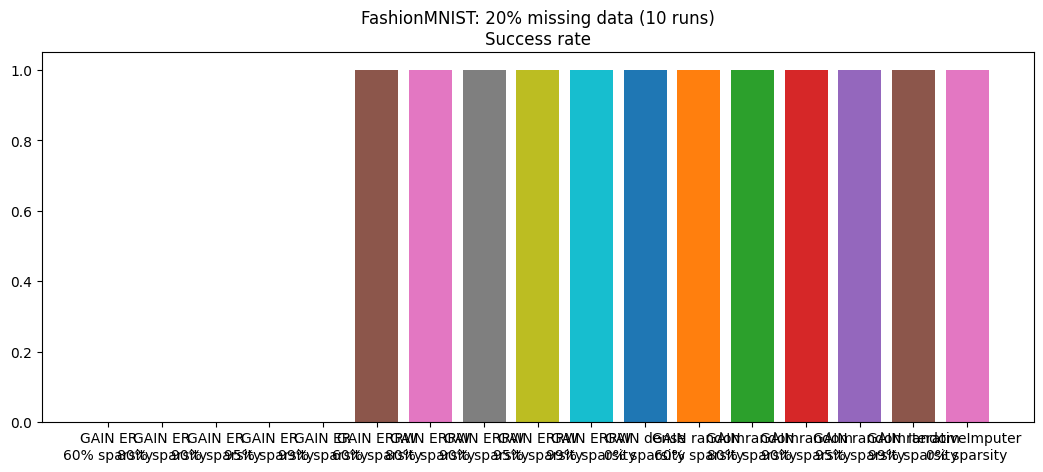

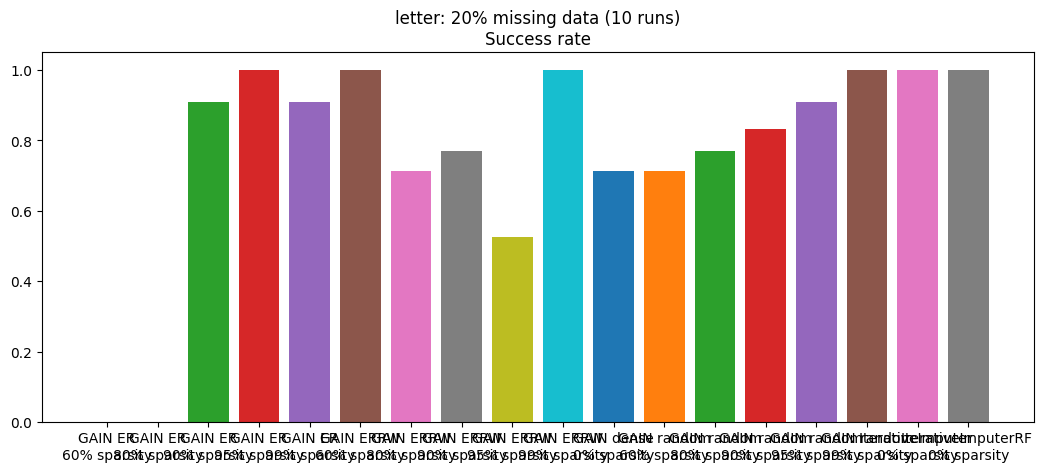

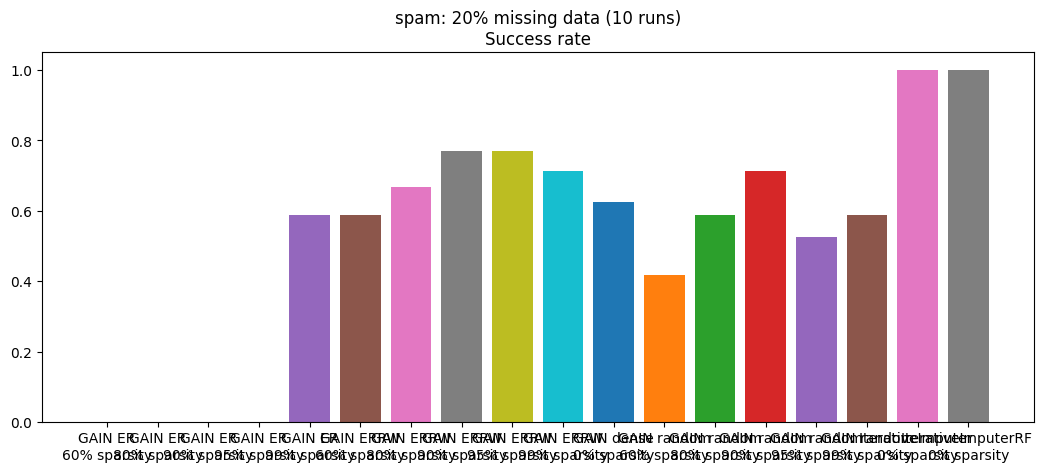

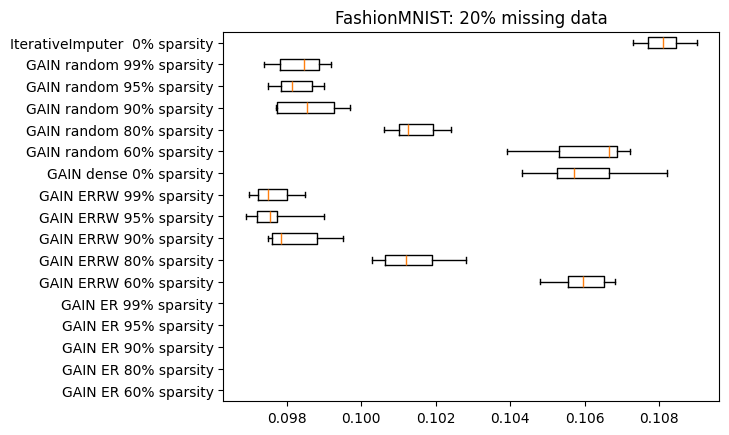

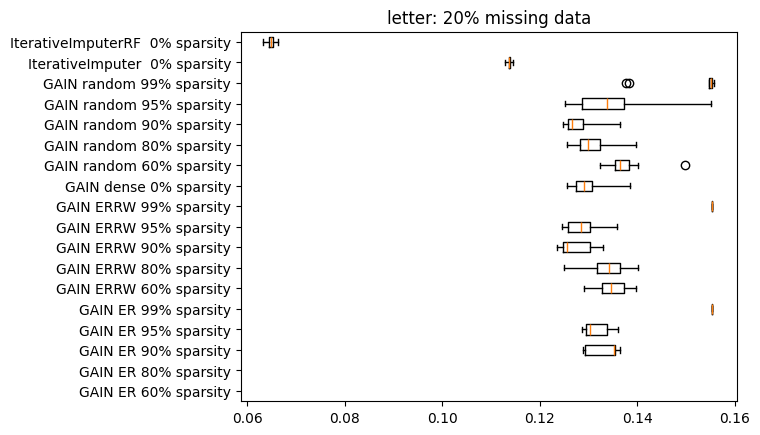

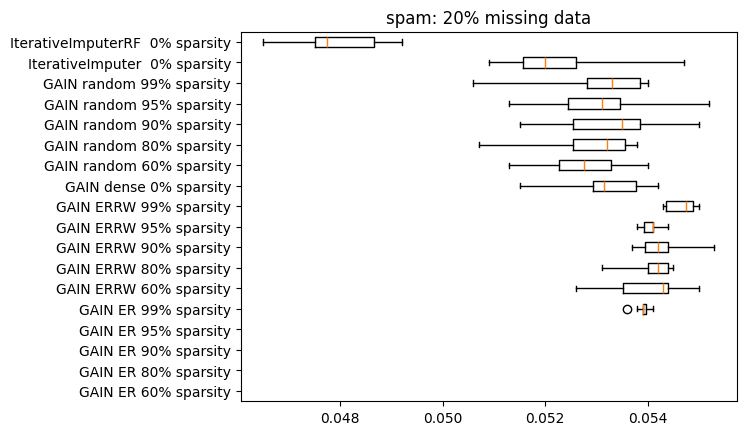

In [237]:
plot_rmse(metrics, save=True)
plot_success_rate(metrics)
box_plot(metrics, IQR=3)